In [1]:
import pandas as pd

import numpy as np
from numpy import random

from maxijdefs import *

from astropy.io import fits
from scipy.signal import fftconvolve

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
def lc_detrend(photin):
    photout=np.zeros(len(photin))
    for i in range(len(photin)):
        i1=i-500
        i2=i+500
        if i1<0:
            i1=0
        if i2>len(photin):
            i2=len(photin)
        photout[i]=photin[i]-np.median(photin[i1:i2])

    return photout

In [3]:
def photlc_2_ts(t5,maxiphot5):
    # takes t, phot and turns it into a time series
    
    dt=(np.max(t5)-np.min(t5)).astype(int)
    print dt
    f=np.zeros(dt+1)
    
    t0=(t5-np.min(t5)).astype(int)
    f[t0]=maxiphot5[:]
    
    return f

In [4]:
def logbin(f,p,df):
    #df = step size in log frequency
    fx=np.zeros(len(f))
    px=np.zeros(len(p))
    fx[:]=f[:]
    fx[0]=fx[1]
    p0=p[0]
    px[:]=p[:]
    px[0]=0.

    fl=np.log10(fx)
    nel=len(f)

    fmin=fl[1]
    fmax=np.max(fl)

    nf=np.round((fmax-fmin)/df).astype(int)
    f2=np.arange(nf)*df+fmin
    p2=np.zeros(nf)

    for i in range(nf):
        fa=10.**f2[i]
        fb=10.**(f2[i]+df)
        fm=(fa+fb)/2.0
        dff=fm-fa
        if len(f[np.abs(f-fm)<=dff])>0:
            p2[i]=np.mean(px[np.abs(f-fm)<=dff])

    return f2,p2

In [5]:
def tsclean(tsin,fluxmin):
    # interpolates over gaps in time series
    # gaps defined by <fluxmin
    
    n=len(tsin)
    tsout=np.zeros(n)
    tsout[tsin>=fluxmin]=tsin[tsin>=fluxmin]
    index_bad=np.argwhere(tsin<fluxmin)
    index_good=np.argwhere(tsin >=fluxmin)
    x=np.arange(n)
    index_fixed=list()
    
    for i in index_bad:
        if int(i) not in index_fixed:
            
            n1=i[0]-1 #last good data point
            dindex=index_good-i
            n2=np.min(index_good[dindex>0]) # get the minimum value
            dn=n2-n1
            df=tsin[n2]-tsin[n1]
            #print df/dn
            tsout[n1:n2]=tsin[n1]+(df/dn)*np.arange(dn.astype(int))
        
            for j in np.arange(n1,n2):
                index_fixed.append(int(j))
        
    return tsout

In [6]:
def pds_chunk128(t,flx,t1,t2):
    # takes time series - not lightcurve - time and flx
    # extracts time from t1 to t2
    # calculates power spectrum in 128s segments and returns
    
    t_span=t2-t1
    n_chunk=np.round(t_span/128.0).astype(int)
    
    print t_span, n_chunk
    
    dt2=128.0/2.0 # half-width of chunk
    
    for i in range(n_chunk):
        ty=t-((i*dt2*2)+dt2+t1)
        y=flx[np.abs(ty)<=dt2]
        if i==0:
            flen=len(y)/2
            print i, flen
            p=np.zeros([n_chunk,flen])
            f=np.arange(flen)/(dt2*2)
        af=np.fft.fft(y)
        p[i,:]=np.abs(af[:flen])**2
        
    ptot=np.sum(p,axis=0)
    
    return f,p,ptot


In [7]:
def p_2_logp(f,p,df,n_avg):
    # takes output of pds_chunk128-style program
    # averages over n_avg pieces, and logbins the 2D array
    
    nt=p.shape[0] # number of power spectra
    
    for i in range(nt):
        i1=i-n_avg/2
        i2=i1+n_avg/2
        if i1<0:
            i1=0
        if i2>(nt-1):
            i2=nt-1
        pmean=np.mean(p[i1:i2+1,:],axis=0)/(np.mean(p[i1:i2+1,0])**0.5)
        dumf,dump=logbin(f,pmean,df)
        if i==0:
            nf=len(dump[dump>0])
            p2=np.zeros([nt,nf])
            f2=dumf[dump>0]
        p2[i,:]=dump[dump>0]
        
    return f2,p2

In [8]:
#read data
path = './maxij_data_copies/'
night = '2018-03-28'

#read in data as pandas dataframe:
data = pd.read_pickle(path+'data_'+night+'.pkl')
# print data
print len(data)

11729


In [9]:
#get phot and time data
tyc_phot = data['phot_tyc']
maxij_phot = data['phot_maxij']
ref2_phot = data[ 'phot_ref2']
ref3_phot = data['phot_ref3']
ref4_phot = data[ 'phot_ref4']
ref5_phot = data['phot_ref5']
ref6_phot = data['phot_ref6']

time = data['os_time']

fID = data['fileID']

In [10]:
# # print len(data)
# data.loc[str(len(data))]

In [11]:
data['maxij_flux'] = data['phot_maxij']
data['tyc_flux'] = data['phot_tyc']
data['ref_flux'] = data['phot_ref3']+data['phot_ref4']+data["phot_ref5"]

In [12]:
# check for NaNs and set them to 0 if they exist, ie: 
i = data[np.isnan(data['maxij_flux'])]['fileID']
print 'maxij ', i
data.loc[i,'maxij_flux'] = 0.0

i = data[np.isnan(data['tyc_flux'])]['fileID']
print 'tyc ', i
data.loc[i,'tyc_flux'] = 0.0

i = data[np.isnan(data['ref_flux'])]['fileID']
print 'ref ', i
data.loc[i,'ref_flux'] = 0.0



#detrend the light curve
# maxi2=lc_detrend(maxij_phot)

maxij  Series([], Name: fileID, dtype: object)
tyc  Series([], Name: fileID, dtype: object)
ref  Series([], Name: fileID, dtype: object)


In [13]:
#uncleaned data chunk test

ts = np.arange(128)

# step 2: choose t0

t0 = 500
tseries = fID[t0:t0+11000]

mphot = data.loc[tseries,'maxij_flux']
f,pmax,pmaxtot = pds_chunk128(ts,mphot,0,128)

tphot = data.loc[tseries,'tyc_flux']
f,ptyc,ptyctot = pds_chunk128(ts,tphot,0,128)

rphot = data.loc[tseries,'ref_flux']
f,pref,preftot = pds_chunk128(ts,rphot,0,128)


128 1
0 64
128 1
0 64
128 1
0 64


/home/amanda/anaconda2/lib/python2.7/site-packages/pandas/core/internals.py:262: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11000 but corresponding boolean dimension is 128
  return self.values[slicer]
/home/amanda/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:1754: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11000 but corresponding boolean dimension is 128
  result = getitem(key)


In [14]:
# data.loc[]

In [15]:
# lc1 = mphot
lct = data.loc[tseries,'os_time']+8.5
ts1 = photlc_2_ts(lct,mphot)
# print lct[0]
# print len(ts1)

11894


In [16]:
ts1a = mphot[100:900]
ts1b = mphot[110:910]

ts1a = np.asarray(ts1a)
ts1b = np.asarray(ts1b)

# print len(ts1a)
# print len(ts1b)

# print ts1a

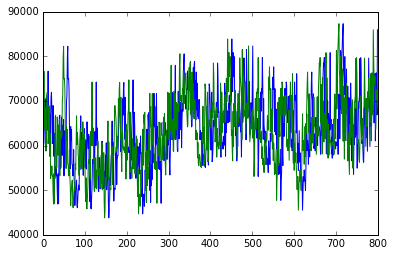

In [17]:
plt.plot(ts1a)
plt.plot(ts1b)
# print ts1a

In [18]:
dum0a=fftconvolve(ts1a,ts1a[::-1]) # ACF for ts1a
dum0b=fftconvolve(ts1b,ts1b[::-1]) # ACF for ts1a

dum1=fftconvolve(ts1a,ts1b[::-1]) # cross-correlate

799
799


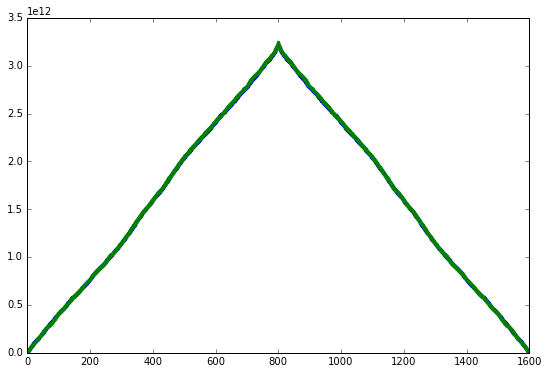

In [19]:
#plot auto correlations
fig,ax=plt.subplots(figsize=[9,6])
ax.plot(dum0a,'.')
ax.plot(dum0b,'.')

# ax.set_xlim(400,1200)
#ax.plot(np.abs(dum1))

print np.argmax(dum0a)
print np.argmax(dum0b)

799


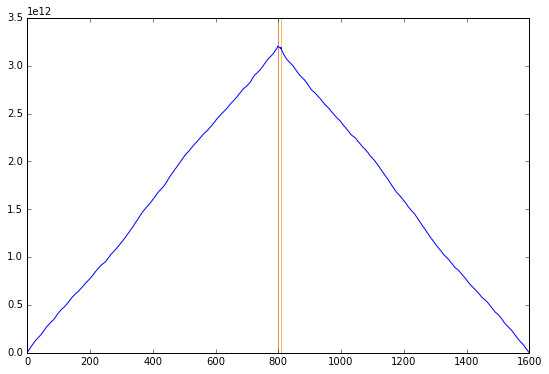

In [20]:
#plot correlation 
fig,ax=plt.subplots(figsize=[9,6])
# ax.set_xlim(1200,1400)
# ax.set_xlim(750,850)


# ax.plot(2.*dum1-dum0a-dum0b)
plt.plot([799,799],[0e12,3.5e12],'r',alpha=.5)
plt.plot([809,809],[0e12,3.5e12],'y',alpha=.7)
ax.plot(dum1)
print np.argmax(dum1)

809


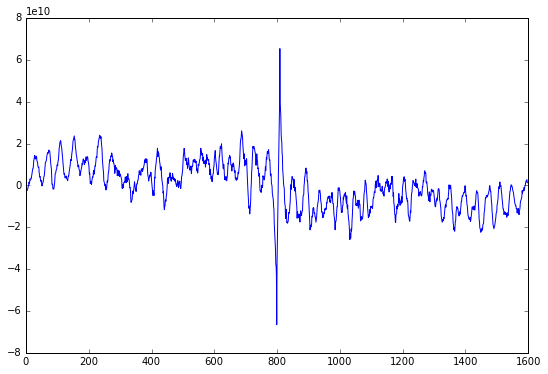

In [21]:
#plot correlation but subtract the autocorrelation fn
fig,ax=plt.subplots(figsize=[9,6])
# ax.set_xlim(750,850)
dum1diff = 2.*dum1-dum0a-dum0b
ax.plot(dum1diff)

# plt.plot([799,799],[-8e10,8e10],'r')
# plt.plot([809,809],[-8e10,8e10],'y')

print np.argmax(dum1diff)

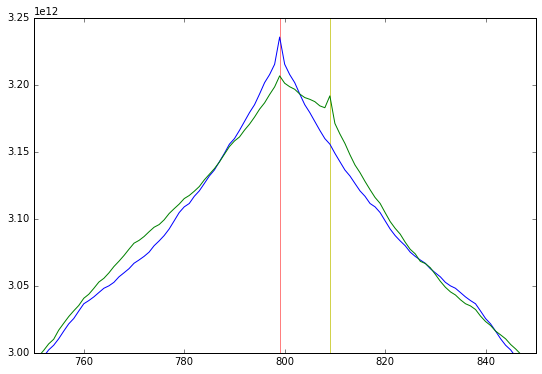

In [22]:
#plot correlation AND one of the autocorrelations
#difference shows the "lag" of 10 points
fig,ax=plt.subplots(figsize=[9,6])
ax.set_xlim(750,850)
ax.set_ylim(3e12,3.25e12)
plt.plot([799,799],[0e12,3.5e12],'r',alpha=.5)
plt.plot([809,809],[0e12,3.5e12],'y',alpha=.7)
ax.plot(dum0a)
ax.plot(dum1)

In [23]:
# print np.argmax(dum0a)
# print np.argmax(dum0b)
# print np.argmax(dum1)

In [24]:
t=np.arange(len(ts1a))/10.
# print t

In [25]:
jnk1=np.fft.fft(ts1a)
jnk2=np.fft.fft(ts1b)

(0.0, 0.8)

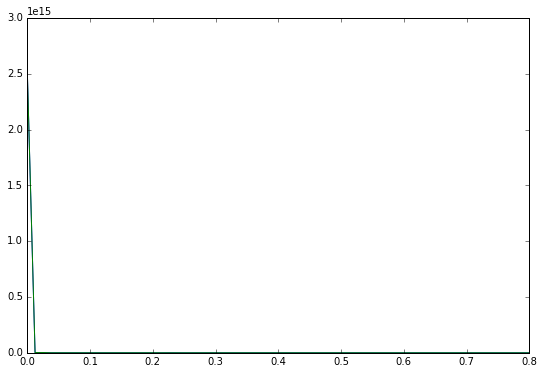

In [26]:
nel2=len(jnk1)/2
f=np.arange(nel2)/np.max(t)

fig,ax=plt.subplots(figsize=[9,6])
ax.plot(f,np.abs(jnk1[:nel2]**2))
ax.plot(f,np.abs(jnk2[:nel2]**2))

# ax.set_ylim(0.0,10e15)
# ax.set_xlim(0.0,0.02)
ax.set_xlim(0.0,0.8)

In [33]:
print data['os_time'][0]

1522221903.04


In [38]:
# unix epoch timestamp - nicer absolute time
# both at 2018-03-28 08:05:21.000 UTC
dt = 1522224321-133689923
print dt

1388534398


In [39]:
import time

In [45]:
print time.gmtime(1522224321)


time.struct_time(tm_year=2018, tm_mon=3, tm_mday=28, tm_hour=8, tm_min=5, tm_sec=21, tm_wday=2, tm_yday=87, tm_isdst=0)


In [46]:
time.strftime('%m/%d/%Y %H:%M:%S',  time.gmtime(1522224321))

'03/28/2018 08:05:21'